## This code was modified from https://github.com/MankaranSingh/Auto-Birds-Eye
See https://medium.com/asap-report/from-semantic-segmentation-to-semantic-birds-eye-view-in-the-carla-simulator-1e636741af3f for info about the 4-camera dataset used here

Before running this notebook, ensure that:
1. "Autonomous Driving" folder (https://drive.google.com/drive/u/0/folders/1GG1uDsiTSbkGYJoN4YJJ7LaQx2F8uJB8) is shared with you
2. create a shortcut to "Autonomous Driving" folder in your "My Drive"

## Initialize

In [1]:
from google.colab import drive
bev_folder = './drive/My Drive/Autonomous Driving/bev_generation_mapping/'
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import numpy as np
import cv2
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from keras.utils import to_categorical

import time
import keras.backend as K
from keras import Input, Model
from keras.layers import Convolution2D, LeakyReLU, BatchNormalization, Conv2D, UpSampling2D, Subtract, Concatenate, Softmax, Dropout, Activation,MaxPooling2D, Flatten, Dense, Lambda, Reshape, concatenate, ZeroPadding2D, Cropping2D
from keras.optimizers import Adam
import tensorflow as tf
from PIL import Image

In [3]:
# mapping from "original" 13-label dataset to "simplified" 3-label dataset
LABELS_MAPPING = {
    0:  0,  # None         -> Nonroad
    1:  0,  # Buildings    -> Nonroad
    2:  0,  # Fences       -> Nonroad
    3:  0,  # Other        -> Nonroad
    4:  2,  # Pedestrians  -> Obstacles
    5:  0,  # Poles        -> Nonroad
    6:  1,  # RoadLines    -> Roads
    7:  1,  # Roads        -> Roads
    8:  0,  # Sidewalks    -> Nonroad
    9:  0,  # Vegetation   -> Nonroad
    10: 2,  # Vehicles     -> Obstacles
    11: 0,  # Walls        -> Nonroad
    12: 0,  # TrafficSigns -> Nonroad
}

# 3-label "RGB" dataset labels
LABELS = {
    0: 'Nonroad',       # colored red
    1: 'Road',          # colored green
    2: 'Obstacles',     # colored blue
}

# switch red and green for final image (request by James)
RG_MAPPING = {
    0: 1,
    1: 0,
    2: 2
}

In [4]:
# This dataset has 3 labels
!cp "/content/drive/MyDrive/Autonomous Driving/bev_generation_mapping/data_rgb/data_rgb.zip" .
!unzip -qo 'data_rgb.zip'

In [5]:
# This dataset has 13 labels
!gdown "https://drive.google.com/uc?id=1x0JdeA2Mo_QvYIJDHMfempoy2R675gMi" -O "birds_eye_data.zip"
!unzip -qo 'birds_eye_data.zip'

Downloading...
From: https://drive.google.com/uc?id=1x0JdeA2Mo_QvYIJDHMfempoy2R675gMi
To: /content/birds_eye_data.zip
100% 584M/584M [00:19<00:00, 30.7MB/s]


In [6]:
import os
print(len(os.listdir('data_rgb/front')))
print(len(os.listdir('data_rgb/top')))

46000
46000


## Reloading Data

In [69]:
# front: (all colors), (RGB)
# top:   (all colors), (RGB)

rows = 2
columns = 2

def plot_cameras(sequence_number):

    fig=plt.figure(figsize=(20, 20))
    imgs = []
    cameras = ['front','top']

    cnt = 0
    for cam in cameras:
        # all colors
        sample = np.load(f"./data/{cam}/{sequence_number}.npy")
        fig.add_subplot(rows, columns, cnt+1)
        plt.imshow(sample, cmap='gist_stern')
        cnt += 1

        # reduced to rgb
        sample = np.load(f"./data_rgb/{cam}/{sequence_number}.npy")
        sample_rgb = np.empty([sample.shape[0], sample.shape[1], 3])
        sample = np.vectorize(RG_MAPPING.get)(sample)

        for i in range(3):
            sample_rgb[:, :, i] = np.where(np.isin(sample, i), 1, 0)
        fig.add_subplot(rows, columns, cnt+1)
        plt.imshow(sample_rgb)
        cnt += 1

    plt.show()

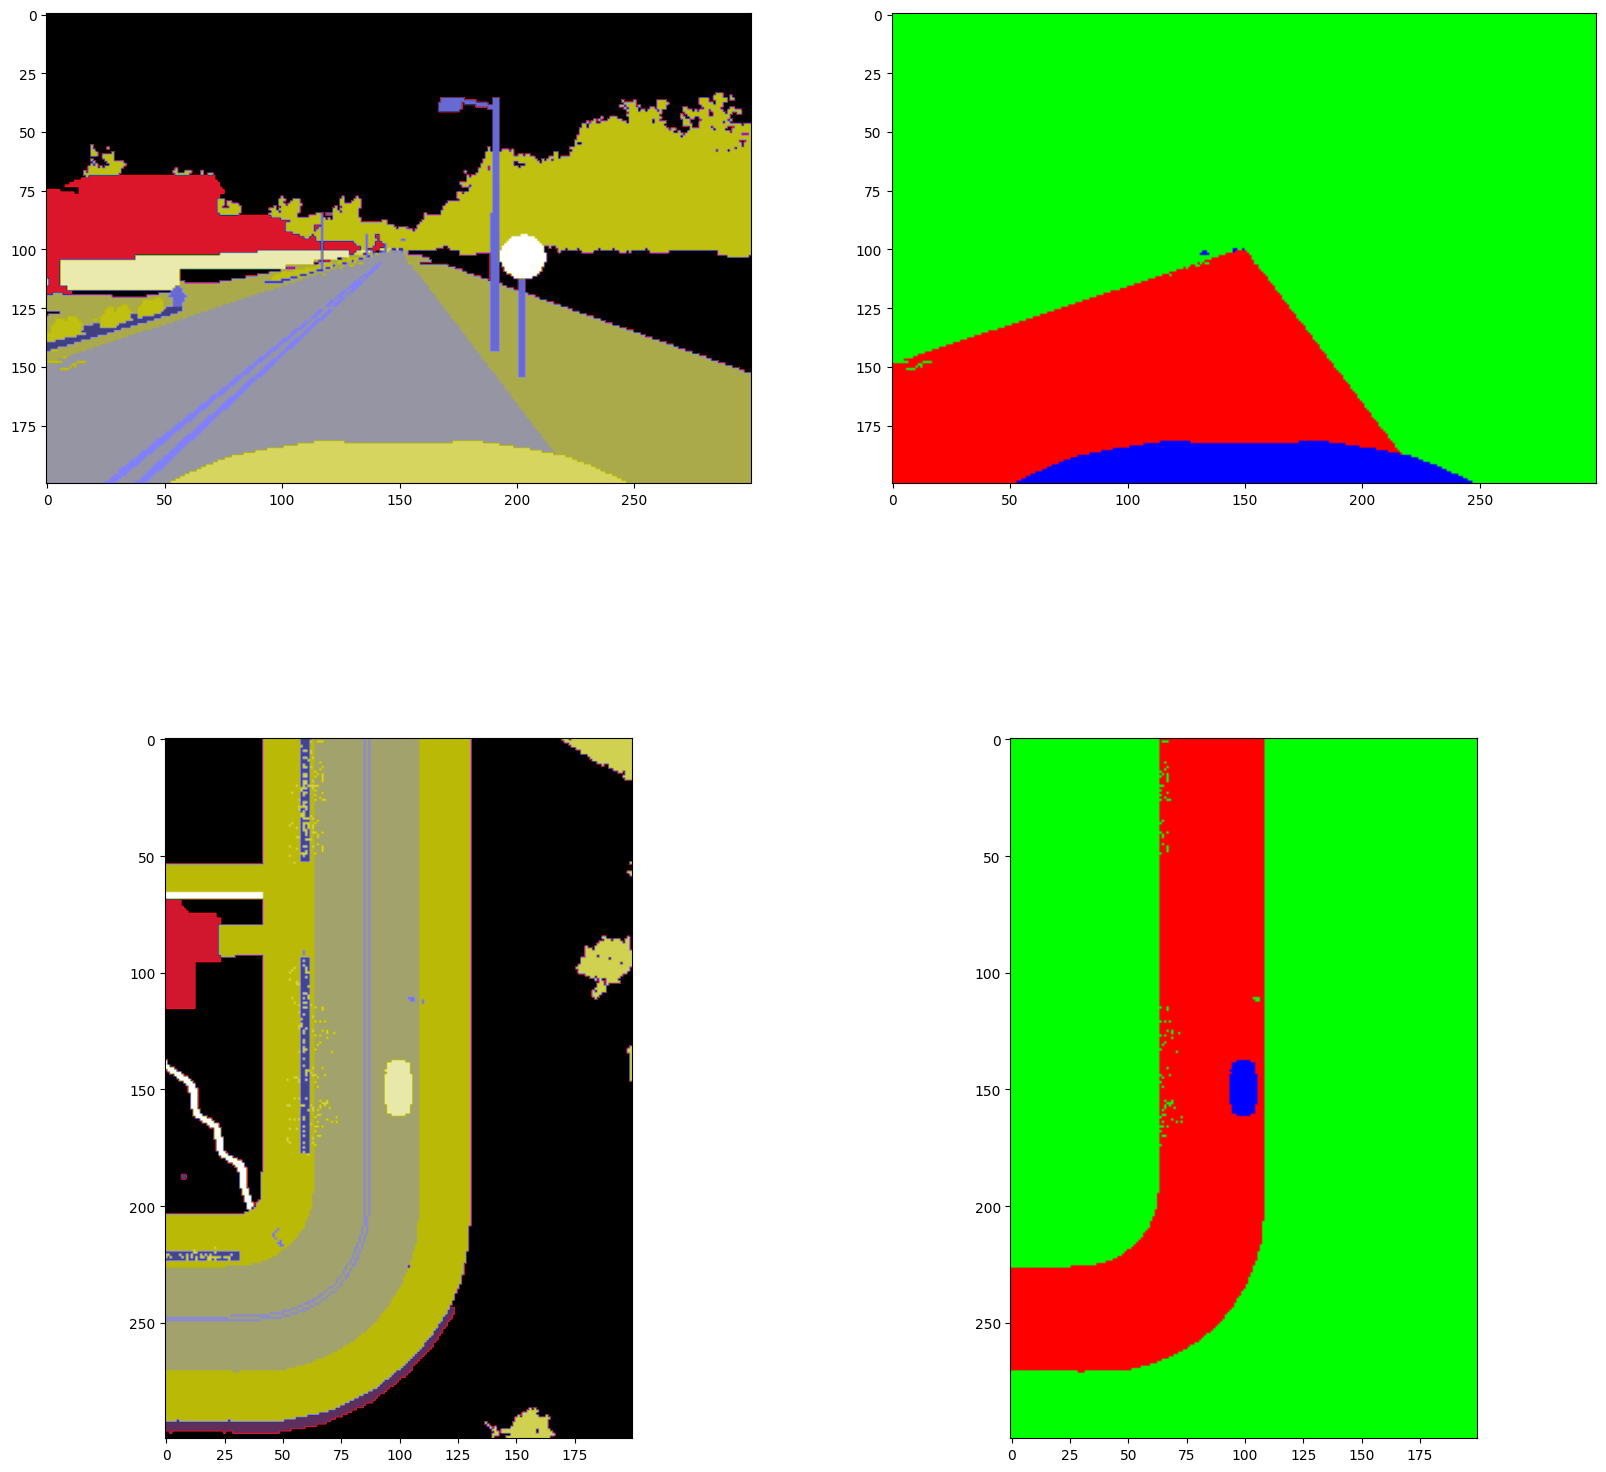

In [70]:
N = 1002
# print(np.load(f'./data_rgb/front/{N}.npy').shape)
# print(np.load(f'./data_rgb/top/{N}.npy').shape)
plot_cameras(N)

In [9]:
import os
def get_paths(val_size=5000):
    img_paths = []

    for i in range(len(os.listdir('./data_rgb/top'))):
        path = f'{i}.npy'
        img_paths.append(path)

    return pd.DataFrame({'path':img_paths[:-val_size]}), pd.DataFrame({'path':img_paths[-val_size:]})

In [10]:
img_paths_train, img_paths_val = get_paths() # 41k training imgs + 5k validation imgs = 46k
img_paths_train

,path
0,0.npy
1,1.npy
2,2.npy
3,3.npy
4,4.npy
...,...
40995,40995.npy
40996,40996.npy
40997,40997.npy
40998,40998.npy


## Setting up Data Generators

In [11]:
# convert RGB image to Nonroad-Road-Obstacles image
# for each channel (eg. Obstacles): 1=has that label, 0=doesn't have that label
def img_to_categorical(img, needed_labels):
    cat = np.empty((img.shape[0], img.shape[1], len(needed_labels)))
    for channel, label in enumerate(needed_labels):
        cat[:, :, channel] = np.where(np.isin(img, label), 1, 0)
    return cat

def categorical_to_img(cat):  
    img = np.argmax(cat, axis=-1)
    return img

# Given "image" (2D matrix of labels), plot the corresponding RGB image
def plot_rgb(img):
    rgb = np.empty([img.shape[0], img.shape[1], 3])
    for i in range(3):
        rgb[:, :, i] = np.where(np.isin(img, i), 1, 0)
    plt.imshow(rgb)

needed_labels = [0, 1, 2]

In [12]:
from tensorflow.keras.utils import Sequence

class DataGenerator2D(Sequence):
    """Generates data for Keras
    Sequence based data generator. Suitable for building data generator for training and prediction.
    """
    def __init__(self, img_paths, base_path, to_fit=True, batch_size=32, shuffle=True, needed_classes = []):
    
        self.img_paths = img_paths.copy()
        self.base_path = base_path
        self.to_fit = to_fit
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.needed_classes = needed_classes
        self.on_epoch_end()
    
    def __len__(self):
        """Denotes the number of batches per epoch
        :return: number of batches per epoch
        """
        return int(len(self.img_paths) // self.batch_size)

    def __getitem__(self, index):
        """Generate one batch of data
        :param index: index of the batch
        :return: X and y when fitting. X only when predicting
        """
        # Generate indexes of the batch
        current_indexes = list(range(index * self.batch_size, (index + 1) * self.batch_size))
        img_paths_temp = self.img_paths[current_indexes]

        # Generate data
        X = self._generate_X(img_paths_temp)

        if self.to_fit:
            y = self._generate_y(img_paths_temp)
            return X, y
        else:
            return X

    def on_epoch_end(self):
        """Updates indexes after each epoch
        """
        if self.shuffle == True:
            indices = np.arange(len(self.img_paths))
            np.random.shuffle(indices)
            self.img_paths = self.img_paths[indices]
            self.img_paths.reset_index(drop=True, inplace=True)


    def _generate_X(self, img_paths_temp):
        """Generates data containing batch_size images
        :param img_paths_temp: list of label ids to load
        :return: batch of images
        """
        # Initialization
        X = []

        # Generate data
        for idx, path in zip(img_paths_temp.index, img_paths_temp):
            # Store sample
            img = self._load_image(path, front=True)
            X.append(img)

        return np.array(X)

    def _generate_y(self, img_paths_temp):

        y = []

        for idx, path in zip(img_paths_temp.index, img_paths_temp):
            # Store sample
            img = self._load_image(path, front=False)
            y.append(img) 
        return np.array(y)

    def _load_image(self, image_path, front=True):
        if front:
            img_dir =  '/front/'
        else:
            img_dir =  '/top/'
        img = np.load(self.base_path + img_dir + image_path)
        img = img[::2, ::2]                                         # Downsampling image by factor of 2
        img = np.vectorize(RG_MAPPING.get)(img)                     # Swap red and green

        if not front:
            img = img[3:(img.shape[0]//2)]                          # Cut off the top half
            img = np.rot90(img, 3)                                  # Rotate so car is on the left
            img = img[2:-2, 8:]                                     # Crop Image to make dimensions divisible by 8 
                                                                    # Crop off the hood of the car as well
            img = cv2.resize(img.astype('float'), dsize=(72, 80))   # Resize to 80 x 72 x 3 image (model output)
            img = img_to_categorical(img, self.needed_classes)

        else:
            img = img[2:-18, 3:-3]                                  # Crop Image to make dimensions divisible by 8 
                                                                    # Crop off the hood of the car as well
            img = img_to_categorical(img, self.needed_classes)

        return img

In [13]:
train_generator = DataGenerator2D(img_paths_train['path'], './data_rgb', batch_size=32, shuffle=True, needed_classes=needed_labels)
val_generator = DataGenerator2D(img_paths_val['path'], './data_rgb', batch_size=1, shuffle=False, needed_classes=needed_labels)

In [14]:
# Test the generator
X, y = train_generator.__getitem__(0)
print(X.shape, y.shape)

input_shape = X.shape[1:]
print(input_shape)

(32, 80, 144, 3) (32, 80, 72, 3)
(80, 144, 3)


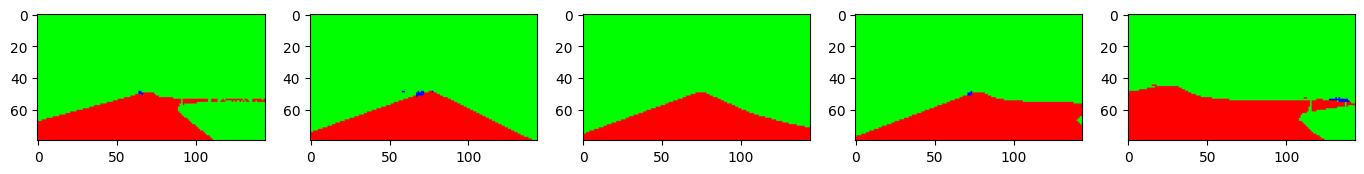

In [15]:
fig=plt.figure(figsize=(17, 17))
columns = 5
rows = 1
for i in range(1, columns*rows + 1):
    img = X[i-1]
    fig.add_subplot(rows, columns, i)
    # plt.imshow(categorical_to_img(img), cmap='gist_stern', vmin=0, vmax=len(needed_labels)-1)
    plot_rgb(categorical_to_img(img))
plt.show()

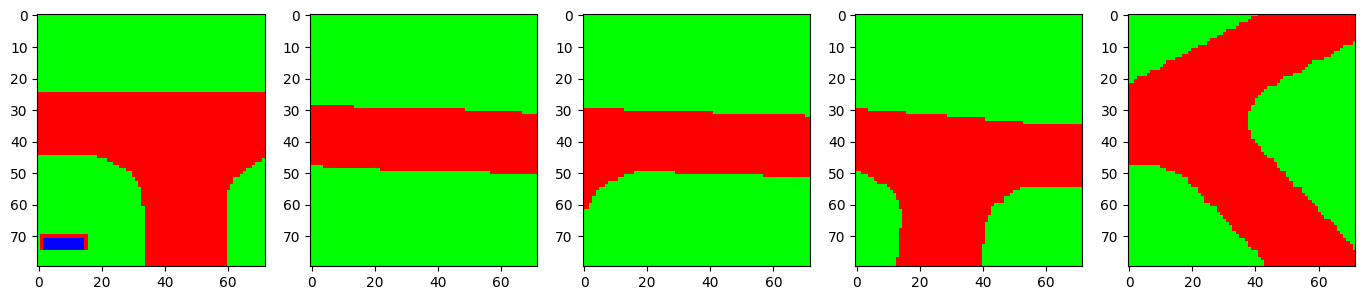

In [16]:
fig=plt.figure(figsize=(17, 17))
columns = 5
rows = 1
for i in range(1, columns*rows + 1):
    img = y[i-1]
    fig.add_subplot(rows, columns, i)
    # plt.imshow(np.rot90(categorical_to_img(img), 3), cmap='gist_stern', vmin=0, vmax=len(needed_labels)-1)
    plot_rgb(categorical_to_img(img))
plt.show()

In [17]:
import time
import keras.backend as K
from keras import Input, Model
from keras.layers import Convolution2D, LeakyReLU, BatchNormalization, UpSampling2D, Subtract, Concatenate, Softmax, Dropout, Activation,MaxPooling2D, Flatten, Dense, Lambda, Reshape, concatenate, ZeroPadding2D, Cropping2D
from keras.optimizers import Adam
from keras import Sequential

In [18]:
# UNet Generator is worse!

# def build_unet_generator(needed_labels):

#   """
#   Create U-Net Generator using the hyperparameter values defined
#   below
#   """

#   kernel_size = [8, 6, 4, 6, 6, 8]
#   strides = 2
#   leakyrelu_alpha = 0.2
#   upsampling_size = 2
#   output_channels = len(needed_labels)
#   input_shape = (96, 144, len(needed_labels))

#   # Setting up the input
#   input_layer = Input(shape=input_shape)

#   # Encoder Network

#   # 1st Convolutional block in the encoder network
#   encoder1 = Convolution2D(filters=64, kernel_size=8,
#   padding='same',
#   strides=strides)(input_layer)
#   encoder1 = LeakyReLU(alpha=leakyrelu_alpha)(encoder1)
#   # 2nd Convolutional block in the encoder network
#   encoder2 = Convolution2D(filters=128, kernel_size=6,
#   padding='same',
#   strides=strides)(encoder1)
#   encoder2 = BatchNormalization()(encoder2)
#   encoder2 = LeakyReLU(alpha=leakyrelu_alpha)(encoder2)
#   # 3rd Convolutional block in the encoder network
#   encoder3 = Convolution2D(filters=256, kernel_size=4,
#   padding='same',
#   strides=strides)(encoder2)
#   encoder3 = BatchNormalization()(encoder3)
#   encoder3 = LeakyReLU(alpha=leakyrelu_alpha)(encoder3)

#   # 6th Upsampling Convolutional block in the decoder network
#   decoder6 = UpSampling2D(size=upsampling_size)(encoder3)
#   decoder6 = Convolution2D(filters=128, kernel_size=6,
#   padding='same')(decoder6)
#   decoder6 = BatchNormalization()(decoder6)
#   decoder6 = concatenate([decoder6, encoder2])
#   decoder6 = LeakyReLU(alpha=leakyrelu_alpha)(decoder6)
#   # 7th Upsampling Convolutional block in the decoder network
#   decoder7 = UpSampling2D(size=upsampling_size)(decoder6)
#   decoder7 = Convolution2D(filters=64, kernel_size=6,
#   padding='same')(decoder7)
#   decoder7 = BatchNormalization()(decoder7)
#   decoder7 = concatenate([decoder7, encoder1])
#   decoder7 = LeakyReLU(alpha=leakyrelu_alpha)(decoder7)


#   # Last Convolutional layer
#   decoder8 = UpSampling2D(size=(2, 1))(decoder7)
#   decoder8 = Convolution2D(filters=output_channels,
#   kernel_size=8, padding='same')(decoder8)
#   decoder8 = Activation('softmax')(decoder8)

#   model = Model(inputs=[input_layer], outputs=[decoder8])

#   return model

# model = build_unet_generator(needed_labels)
# model.summary()

In [19]:
def get_model(needed_labels): # Deeper Autoencoder
    model = Sequential()
  
    model.add(Conv2D(32, (5, 5), strides=2, padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2D(64, (5, 5), strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2D(128, (3, 3), strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2D(128, (3, 3), strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2D(256, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2D(256, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))

    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(256, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))

    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))

    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(32, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))

    model.add(UpSampling2D((2, 1)))
    model.add(Conv2D(32, (5, 5), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Conv2D(len(needed_labels), (5, 5), activation='softmax', padding='same'))

    return model

model = get_model(needed_labels)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 40, 72, 32)        2432      
                                                                 
 batch_normalization (BatchN  (None, 40, 72, 32)       128       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 40, 72, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 20, 36, 64)        51264     
                                                                 
 batch_normalization_1 (Batc  (None, 20, 36, 64)       256       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 20, 36, 64)        0

In [20]:
# Checking if the model can run at real time on current GPU at specifies fps

from time import time
fps = 30

x = np.random.random(input_shape)
start = time()

for i in range(fps):
    out = model.predict(np.array([x]), verbose = 0) # predict silently

print(time() - start)

10.066767454147339


In [21]:
from keras.optimizers import Nadam
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from time import time

optimizer = Nadam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004)
tensorboard = TensorBoard(log_dir = bev_folder+"logs/{}".format(time()))
early_stopping = EarlyStopping(monitor='val_loss', patience=30)

filepath = bev_folder+"Saved Models/model-{epoch:02d}-{val_loss:.5f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False)
callbacks_list = [checkpoint, tensorboard]

In [22]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true) # float32
    y_pred_f = K.flatten(y_pred) # float32
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_multilabel(y_true, y_pred, numLabels=len(needed_labels)):
    dice=0
    for index in range(0, numLabels):                                          
        dice -= dice_coef(y_true[:, :, :, index], y_pred[:, :, :, index])
    return numLabels + dice

def ssim_loss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))

def custom_loss(y_true, y_pred):
    return dice_coef_multilabel(y_true, y_pred) + 5*ssim_loss(y_true, y_pred)

In [ ]:
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.compile(optimizer='adam', loss=custom_loss, metrics=['categorical_accuracy'])

In [ ]:
NUM_EPOCHS = 100

history = model.fit(train_generator, epochs=NUM_EPOCHS, 
                    shuffle=True, callbacks=callbacks_list, 
                    validation_data= val_generator)

Epoch 1/100
1281/1281 [==============================] - ETA: 0s - loss: 1.9993 - categorical_accuracy: 0.9079
Epoch 1: saving model to ./drive/My Drive/Autonomous Driving/bev_generation_mapping/Saved Models/model-01-1.32910.hdf5
1281/1281 [==============================] - 204s 152ms/step - loss: 1.9993 - categorical_accuracy: 0.9079 - val_loss: 1.3291 - val_categorical_accuracy: 0.9260
Epoch 2/100
1281/1281 [==============================] - ETA: 0s - loss: 1.5867 - categorical_accuracy: 0.9432
Epoch 2: saving model to ./drive/My Drive/Autonomous Driving/bev_generation_mapping/Saved Models/model-02-1.17920.hdf5
1281/1281 [==============================] - 196s 153ms/step - loss: 1.5867 - categorical_accuracy: 0.9432 - val_loss: 1.1792 - val_categorical_accuracy: 0.9423
Epoch 3/100
1281/1281 [==============================] - ETA: 0s - loss: 1.5023 - categorical_accuracy: 0.9486
Epoch 3: saving model to ./drive/My Drive/Autonomous Driving/bev_generation_mapping/Saved Models/model-03-1

KeyboardInterrupt: ignored

## Testing the model

In [45]:
from keras.models import load_model

model = load_model(bev_folder + 'Saved Models/model-14-0.93380.hdf5', compile=False)
columns = 3
rows = 1

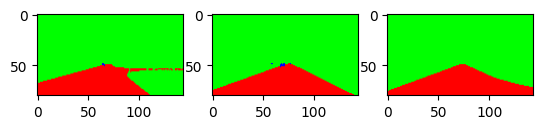

In [59]:
fig=plt.figure()
for i in range(1, columns*rows + 1):
    img = X[i-1]
    fig.add_subplot(rows, columns, i)
    # plt.imshow(categorical_to_img(img), cmap='gist_stern', vmin=0, vmax=len(needed_labels) - 1)
    plot_rgb(categorical_to_img(img))
plt.show()
fig.savefig('orig.png', bbox_inches='tight')

1/1 [==============================] - 0s 22ms/step


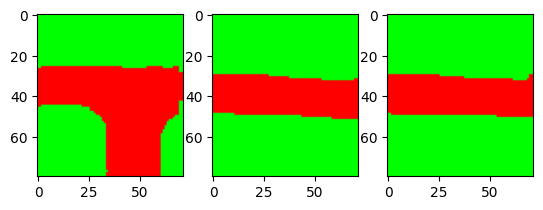

In [60]:
fig=plt.figure()
for i in range(1, columns*rows + 1):
    img = X[i-1]
    pred = model.predict(np.array([img]))
    fig.add_subplot(rows, columns, i)
    # plt.imshow(np.rot90(categorical_to_img(pred[0]), 3), cmap='gist_stern', vmin=0, vmax=len(needed_labels)-1)
    plot_rgb(categorical_to_img(pred[0]))
plt.show()
fig.savefig('pred.png', bbox_inches='tight')

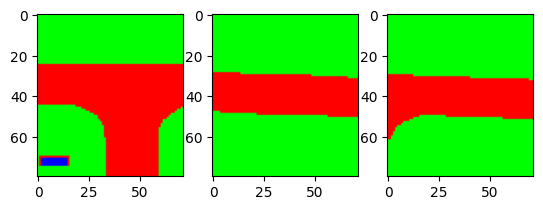

In [61]:
fig=plt.figure()
for i in range(1, columns*rows + 1):
    img = y[i-1]
    fig.add_subplot(rows, columns, i)
    # plt.imshow(np.rot90(categorical_to_img(img), 3), cmap='gist_stern', vmin=0, vmax=len(needed_labels)-1)
    plot_rgb(categorical_to_img(img))
plt.show()
fig.savefig('actual.png', bbox_inches='tight')

In [63]:
## Use this and play video on your own pc by loading the numpy array.

imgs = []

for i in range(len(X)):
    img = X[i]
    pred = model.predict(np.array([img]))
    img = np.rot90(categorical_to_img(pred[0]), 3)
    imgs.append(img.astype('uint8'))

np.save('output7', np.array(imgs))

1/1 [==============================] - 0s 23ms/step


In [64]:
img = X[0]
print('INPUT (Front):', img.shape)
img = y[0]
print('OUTPUT (Top):', img.shape)

INPUT (Front): (80, 144, 3)
OUTPUT (Top): (80, 72, 3)


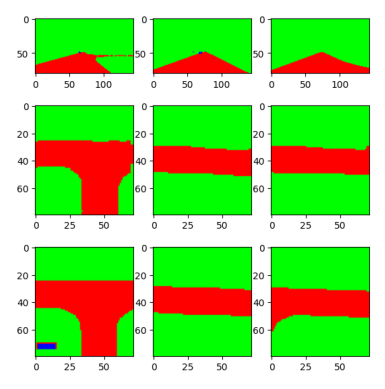

In [74]:
import cv2

orig = cv2.cvtColor(cv2.imread('orig.png'), cv2.COLOR_BGR2RGB)
pred = cv2.cvtColor(cv2.imread('pred.png'), cv2.COLOR_BGR2RGB)
actual = cv2.cvtColor(cv2.imread('actual.png'), cv2.COLOR_BGR2RGB)

full = cv2.vconcat([orig, pred, actual])
plt.axis('off')
plt.imshow(full)
plt.show()